# Data-Driven Modelling of Financial Markets Report

### Task 1 - Download the Dataset

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests

# so warnings dont clutter notebook
import warnings
warnings.filterwarnings('ignore')

In [117]:
# pick an asset to work with from portfolio: e.g. ETH/USD
asset = 'ETH/USD'

pair = asset.replace('/', '-')
df = pd.read_csv(f'../Datasets/Data/data_{pair}.csv')

# convert time data into datetime object, and extract closing prices
df.Time = pd.to_datetime(df.Time)
df.set_index(df.Time, inplace=True)
closing = df.Close

# calculate logarithmic returns
log_returns = np.log(closing) - np.log(closing.shift(1))
log_returns.dropna(inplace=True)

### Task 2 - Plot dataset and calculate statistics

(array([18986., 18987., 18988., 18989., 18990., 18991., 18992., 18993.,
        18994., 18995.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

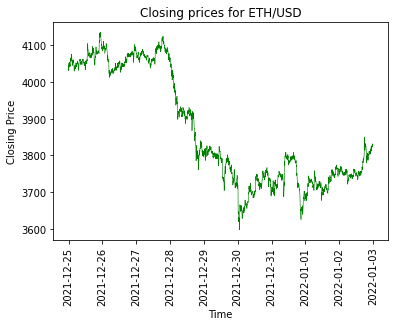

In [118]:
# Plot of closing prices for asset
plt.plot(closing, color='green', linewidth=0.6)
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.title(f'Closing prices for {asset}')
plt.xticks(rotation=90)

In [119]:
# Closing prices statistics
closing.describe()

count    2592.000000
mean     3868.862114
std       154.434284
min      3597.300000
25%      3738.575000
50%      3801.050000
75%      4051.100000
max      4135.400000
Name: Close, dtype: float64

(array([18986., 18987., 18988., 18989., 18990., 18991., 18992., 18993.,
        18994., 18995.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

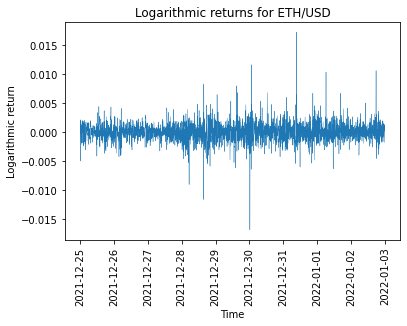

In [120]:
# Plot of log returns
plt.plot(log_returns, linewidth=0.4)
plt.xlabel('Time')
plt.ylabel('Logarithmic return')
plt.title(f'Logarithmic returns for {asset}')
plt.xticks(rotation=90)

In [121]:
# Statistics of log returns
print("Statistics of log returns: \n", log_returns.describe())
skewness = stats.skew(log_returns)
kurtosis = stats.kurtosis(log_returns)

print(f"\nskewness: {skewness}")
print(f"kurtosis: {kurtosis}")

# Volatility can be approximated as the average magnitude of the log returns
volatility = np.mean(np.abs(log_returns))
print(f"\nvolatility: {volatility}")

Statistics of log returns: 
 count    2591.000000
mean       -0.000022
std         0.001693
min        -0.016854
25%        -0.000912
50%         0.000000
75%         0.000841
max         0.017142
Name: Close, dtype: float64

skewness: 0.20414574017420034
kurtosis: 11.562728582443865

volatility: 0.0011896755358963458


### Histogram of data

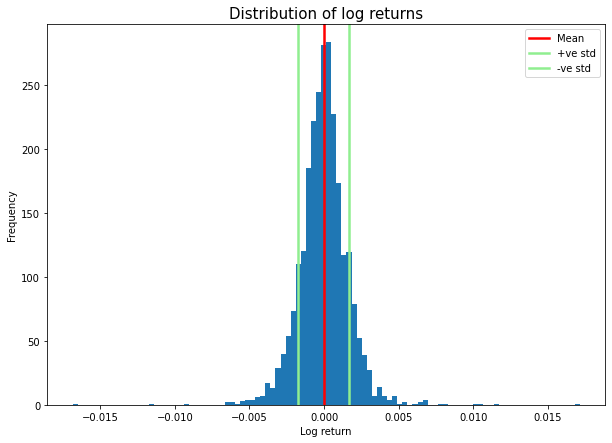

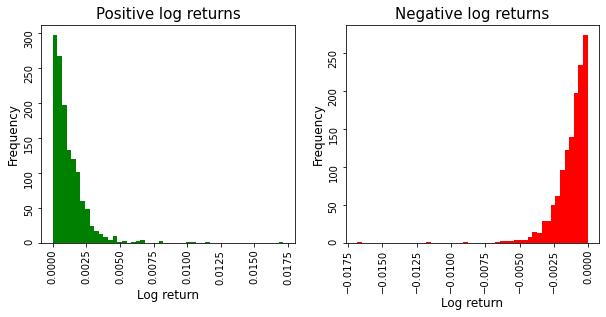

In [122]:
# histogram of logarithmic returns
N_x = 100
mu = np.mean(log_returns)
sigma = np.sqrt(np.var(log_returns))

plt.figure(figsize=(10, 7))
plt.hist(log_returns, bins=N_x)

plt.axvline(mu, color='red', linewidth=2.5, label='Mean')
plt.axvline(mu + sigma, color='lightgreen', linewidth=2.5, label='+ve std')
plt.axvline(mu - sigma, color='lightgreen',linewidth=2.5,  label='-ve std')

plt.xlabel('Log return')
plt.ylabel('Frequency')
plt.title('Distribution of log returns', size=15)
plt.legend()

# positive and negative returns
returns_pos = log_returns[log_returns >= 0]
returns_neg = log_returns[log_returns < 0]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].hist(returns_pos, bins=round(N_x/2), color='green')
ax[0].set_title('Positive log returns', size=15)
ax[0].set_ylabel('Frequency', fontsize=12)
ax[0].set_xlabel('Log return', fontsize=12)
ax[0].tick_params(labelrotation=90)

ax[1].hist(returns_neg, bins=round(N_x/2), color='red')
ax[1].set_title('Negative log returns', size=15)
ax[1].set_ylabel('Frequency', fontsize=12)
ax[1].set_xlabel('Log return', fontsize=12)
ax[1].tick_params(labelrotation=90)

### Fitting a normal distribution

Can demonstrate how well a normal distrbution follows this data.

In [123]:
# Log likelihood function
def log_likelihood(m, s, data):
    log_pdfs = np.array([np.log(stats.norm.pdf(r, loc=m, scale=s)) for r in data])
    loglikelihood = np.sum(log_pdfs)

    return loglikelihood


# testing ranges for scale and location parameters
N_params = 10
location = np.linspace(-0.003, 0.001, N_params)
scale = np.linspace(0.0008, 0.0012, N_params)

# compute exhaustive grid search to find log likelihood of all tested parameters
results = {}

for mu_g in location:
    for sigma_g in scale:
        likelihood = log_likelihood(mu_g, sigma_g, log_returns)
        title = str(f'{mu_g}_{sigma_g}')
        results[title] = {'likelihood': likelihood, 'mu': mu_g, 'sigma': sigma_g}

# find maximum likelihood parameters
maximal_parameters = max(results.items(), key=lambda value: results[value[0]]['likelihood'])[1]

mu_fit = maximal_parameters['mu']
sigma_fit = maximal_parameters['sigma']

print("MLE Parameters:")
print(f"mean = {mu_fit}")
print(f"sigma = {sigma_fit}")

MLE Parameters:
mean = 0.0001111111111111113
sigma = 0.0012


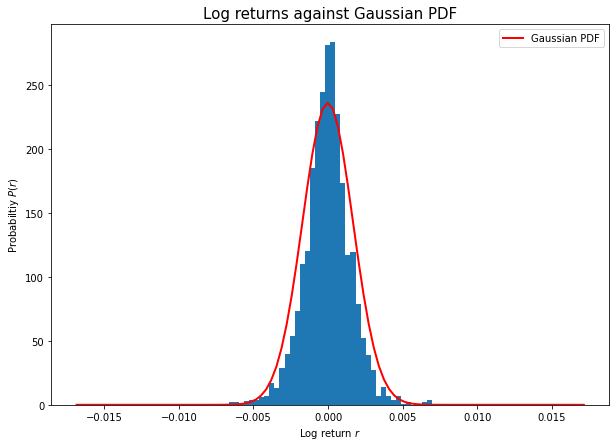

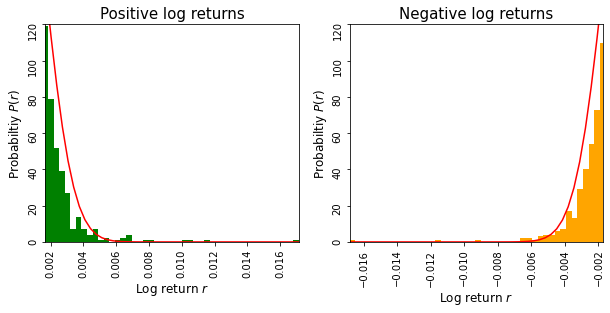

In [124]:
# Compute Gaussian PDF values
x = np.linspace(np.min(log_returns), np.max(log_returns), N_x)
PDF_g = np.exp( - np.power(x - mu, 2) / (pow(sigma, 2) * 2) ) / np.sqrt(pow(sigma, 2) * 2 * np.pi)

# Plot Gaussian PDF against histogram
plt.figure(figsize=(10, 7))
plt.hist(log_returns, bins=N_x)
plt.plot(x, PDF_g, linewidth=2.0, color='red', label='Gaussian PDF')

plt.xlabel(r'Log return $r$')
plt.ylabel(r'Probabiltiy $P(r)$')
plt.title('Log returns against Gaussian PDF', size=15)
plt.legend()

# Plot against positive/getaive returns
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].hist(log_returns, bins=N_x, color='green')
ax[0].plot(x[x >= (mu + sigma)], PDF_g[x >= (mu + sigma)], linewidth=1.5, color='red', label='Gaussian PDF')
ax[0].set_title('Positive log returns', size=15)
ax[0].set_ylabel(r'Probabiltiy $P(r)$', fontsize=12)
ax[0].set_xlabel(r'Log return $r$', fontsize=12)
ax[0].set_ylim([0, 120])
ax[0].set_xlim([mu + sigma, np.max(log_returns)])
ax[0].tick_params(labelrotation=90)

ax[1].hist(log_returns, bins=N_x, color='orange')
ax[1].plot(x[x < (mu - sigma)], PDF_g[x < (mu - sigma)], linewidth=1.5, color='red', label='Gaussian PDF')
ax[1].set_title('Negative log returns', size=15)
ax[1].set_ylabel(r'Probabiltiy $P(r)$', fontsize=12)
ax[1].set_xlabel(r'Log return $r$', fontsize=12)
ax[1].set_ylim([0, 120])
ax[1].set_xlim([np.min(log_returns), mu - sigma])
ax[1].tick_params(labelrotation=90)

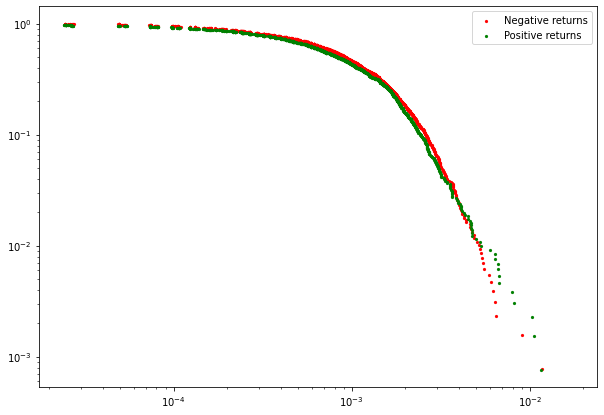

In [125]:
# CCDF = probability of finding data value X larger than a certain value x: P(X > x)
sorted_data_N = np.sort(np.abs(returns_neg))
cdf_N = np.arange(sorted_data_N.shape[0]) / (sorted_data_N.shape[0] - 1)
CCDF_N = 1 - cdf_N

sorted_data_P = np.sort(np.abs(returns_pos))
cdf_P = np.arange(sorted_data_P.shape[0]) / (sorted_data_P.shape[0] - 1)
CCDF_P = 1 - cdf_P

# plot CDF
plt.figure(figsize=(10, 7))
plt.scatter(sorted_data_N, CCDF_N, marker='.', linewidth=0.2, color='red', label='Negative returns')
plt.scatter(sorted_data_P, CCDF_P, marker='.', linewidth=0.2, color='green', label='Positive returns')

plt.xscale('log')
plt.yscale('log')
plt.legend()

In [126]:
# Show how different distributions 

# need to fit normal dist to data

# plot CCDF of normal
normal_data = np.sort(np.random.normal(size=sorted_data_N.shape[0]))
cdf_norm = np.arange(normal_data.shape[0]) / (normal_data.shape[0] - 1)
CCDF_norm = 1 - cdf_norm

# students-t distribution (fat tailed)

### Stationarity of data
- Financial data is inherently non-stationary - i.e. its statistics change over time.
- Logarithmic returns are used to remove the trend in the data, making it stationary.

In [127]:
# show whether original dataset (closing prices) is stationary

# show whether de-trended dataset (log returns) is stationary

### Dependencies
- In GPR, the function `f` being modelled is assumed to follow a multi-variate Normal distribution.
- `y` is the dependent variable, which we evaluate at a set of locations `x`.
- there is a dependency between outputs (i.e. `y` values).
- The dependency of this distribution is defined through the covariance matrix.
- Each variable in the time series is dependent on those that come before it in the computed window.

### Correlation
- covariance matrix is important to GPs as it defines the correlation of the random variable `y` AT inputs `x`.
- GPs allow us to model the correlatons over the dataset.

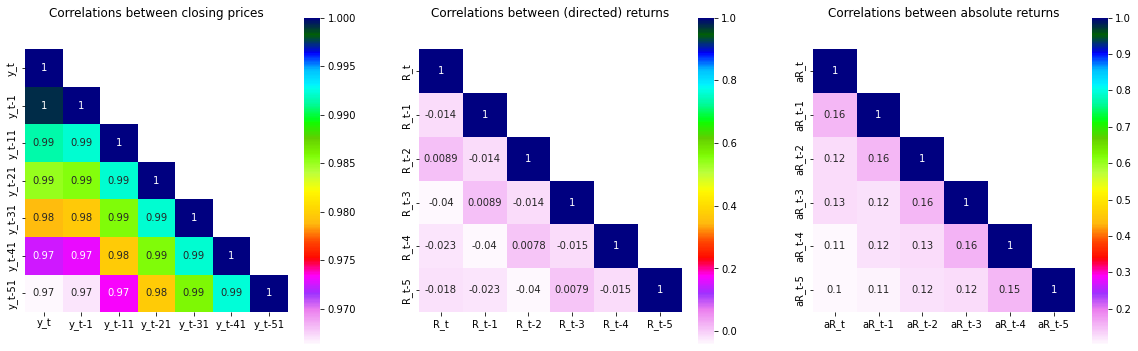

In [205]:
# construct shifted dataset of closing values
y_t = pd.Series(np.array(closing))
close_df = pd.DataFrame(y_t, columns=['y_t'])

for i in range(1, 60, 10):
    close_df[f'y_t-{i}'] = y_t.shift(i)

close_df = close_df.dropna()

# compute the correlation of closing values and closing values shifted back through time-series
corr_matrix_close = close_df.corr()

# define a mask that hides the values in the upper triangular matrix
mask_1 = np.triu(np.ones_like(corr_matrix_close, dtype=bool), k=1)

# genrate heatmap that uses this mask and map
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
sns.heatmap(corr_matrix_close, mask=mask_1, cmap=plt.cm.gist_ncar_r, square=True, annot=True, ax=ax[0])
ax[0].set_title("Correlations between closing prices", y=1.1)


# compute the correlations between returns (and shifted returns over 5 timestep lookback window)
R_t = pd.Series(np.array(log_returns))
rets_df = pd.DataFrame(R_t, columns=['R_t'])

for i in range(1, 6, 1):
    rets_df[f'R_t-{i}'] = R_t.shift(i)

rets_df = rets_df.dropna()

corr_matrix_rets = rets_df.corr()
mask_2 = np.triu(np.ones_like(corr_matrix_rets, dtype=bool), k=1)

sns.heatmap(corr_matrix_rets, mask=mask_2, cmap=plt.cm.gist_ncar_r, square=True, annot=True, ax=ax[1])
ax[1].set_title("Correlations between (directed) returns", y=1.1)


# compute the correlations between absolute returns
aR_t = pd.Series(np.abs(np.array(log_returns)))
abs_rets_df = pd.DataFrame(aR_t, columns=['aR_t'])

for i in range(1, 6, 1):
    abs_rets_df[f'aR_t-{i}'] = aR_t.shift(i)

abs_rets_df = abs_rets_df.dropna()

corr_matrix_abs_rets = abs_rets_df.corr()
mask_3 = np.triu(np.ones_like(corr_matrix_abs_rets, dtype=bool), k=1)

sns.heatmap(corr_matrix_abs_rets, mask=mask_3, cmap=plt.cm.gist_ncar_r, square=True, annot=True, ax=ax[2])
ax[2].set_title("Correlations between absolute returns", y=1.1)

plt.show()


### Causality
- Granger causality test.
- Can only be conducted over stationary datasets.
- Define null hypothesis:
    - Null hypothesis $H_0 \colon$ returns in the past do not Granger cause future returns.
    - Alternative hypothesis $H_1 \colon$ returns in the past do Granger cause future returns.

In [200]:
# conduct Granger causality test: past returns -> future returns
# maxlag = time lag to go back and check causality
print("Granger causality test (returns 4 steps back -> current returns)")
granger_rets = grangercausalitytests(rets_df[['R_t-4', 'R_t']], maxlag=3)

Granger causality test (returns 4 steps back -> current returns)

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2638  , p=0.0390  , df_denom=2582, df_num=1
ssr based chi2 test:   chi2=4.2688  , p=0.0388  , df=1
likelihood ratio test: chi2=4.2653  , p=0.0389  , df=1
parameter F test:         F=4.2638  , p=0.0390  , df_denom=2582, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.2528  , p=0.1053  , df_denom=2579, df_num=2
ssr based chi2 test:   chi2=4.5144  , p=0.1046  , df=2
likelihood ratio test: chi2=4.5105  , p=0.1048  , df=2
parameter F test:         F=2.2528  , p=0.1053  , df_denom=2579, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6337  , p=0.1795  , df_denom=2576, df_num=3
ssr based chi2 test:   chi2=4.9143  , p=0.1782  , df=3
likelihood ratio test: chi2=4.9096  , p=0.1785  , df=3
parameter F test:         F=1.6337  , p=0.1795  , df_denom=2576, df_num=3


In [203]:
# check opposite direction to verify whether causality flows in expected direction
print("Granger causality test (current returns -> returns 4 steps back)")
granger_rets = grangercausalitytests(rets_df[['R_t', 'R_t-4']], maxlag=3)

Granger causality test (current returns -> returns 4 steps back)

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8335  , p=0.3614  , df_denom=2582, df_num=1
ssr based chi2 test:   chi2=0.8344  , p=0.3610  , df=1
likelihood ratio test: chi2=0.8343  , p=0.3610  , df=1
parameter F test:         F=0.8335  , p=0.3614  , df_denom=2582, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5984  , p=0.5497  , df_denom=2579, df_num=2
ssr based chi2 test:   chi2=1.1992  , p=0.5490  , df=2
likelihood ratio test: chi2=1.1989  , p=0.5491  , df=2
parameter F test:         F=0.5984  , p=0.5497  , df_denom=2579, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7224  , p=0.5385  , df_denom=2576, df_num=3
ssr based chi2 test:   chi2=2.1732  , p=0.5373  , df=3
likelihood ratio test: chi2=2.1722  , p=0.5374  , df=3
parameter F test:         F=0.7224  , p=0.5385  , df_denom=2576, df_num=3


Low $p$-values across the time lags ($p < 5\%$) in the first suggest that the null hypothesis $H_0$ can be **rejected**. This indicates that past returns do Granger cause future returns, however as the timelag increases the $p$-value increases, meaning returns in the distant past are less prone to support this rejection of $H_0$.

When we look at the causality between the reversed datasets, we cannot reject the null hypothesis as the $p$ values are large ($p > 5\%$).